# ModelConductor demo

This short tutorial will cover the basic workflow of conducting One-To-One experiments with ModelConductor. The experiment has two distinct parts, i.e. 

1) The process of writing high-frequency process data to an SQLite database is simulated with a mockup function and

2) The database is concurrently polled and the latest database streamed to a dynamical simulation model, distributed as an Functional Mockup Unit (FMU). The model's output is saved to a csv file

The FMU Model is implemented originally in MapleSim and taken from https://github.com/modelica/fmi-cross-check/tree/master/fmus/2.0/cs/win64/MapleSim/2018/CoupledClutches

The input file to the FMU has been trimmed down to first 1.4 seconds (approx. 1400 samples)

For a more detail description of the various ModelConductor components, read the code or see the original publication in [1]

[1] Aho, P. 2019. An Open Source Digital Twin Framework. Master's Thesis. Tampere University

# Preliminaries

Let us examine what we have, i.e., the FMU model and input data. 

In [1]:
from fmpy import dump

In [2]:
dump('CoupledClutches.fmu')


Model Info

  FMI Version       2.0
  FMI Type          Co-Simulation
  Model Name        CoupledClutches
  Description       Model CoupledClutches
  Platforms         win64
  Continuous States 8
  Event Indicators  25
  Variables         148
  Generation Tool   MapleSim (1357016/1357197/1357197)
  Generation Date   2018-10-25T13:27:07Z

Default Experiment

  Stop Time         1.5
  Step Size         0.01

Variables (input, output)

Name                Causality              Start Value  Unit     Description
inputs              input      0.00000000000000000e+00           RI1
outputs[1]          output     1.00000000000000000e+01  rad/s    J1.w
outputs[2]          output     0.00000000000000000e+00  rad/s    J2.w
outputs[3]          output     0.00000000000000000e+00  rad/s    J3.w
outputs[4]          output     0.00000000000000000e+00  rad/s    J4.w


At each timestep, the model accepts one input and produced an output vector of four elements. The expected step size is 0.01 seconds.

Example input data is contained in a csv file:  

In [3]:
# read in the raw data
import pandas as pd
data = pd.read_csv("CoupledClutches_in_sh.csv")

In [4]:
data.head()

,time,inputs
0,0.000,0
1,0.001,0
2,0.002,0
3,0.003,0
4,0.004,0


In [5]:
len(data)

1421

In [6]:
from matplotlib import pyplot as plt

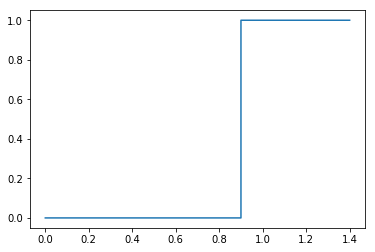

In [7]:
plt.plot(data["time"], data["inputs"])

The input data is essentially a stair function (Clutch engaged / disengaged?)

Let's check the mean time step

In [8]:
data["time"].diff().mean()

0.0009859154761677057

The mean step should be in good accordance with what the model expects

## The data source

Periodical database writes of the mock input data are made, approximating the process of data acquisition from real-world sensory measuremnens

In [9]:
import sqlalchemy as sqla
import pandas as pd
from datetime import datetime as dt
from time import sleep

In [10]:
def simulate_writes(delay=0.01):
    """Simulate a db write between every delay seconds"""
    engine = sqla.create_engine('sqlite:///test.db')
    conn = engine.connect()

    def write_row(row):
        row.to_sql('data', con=conn, if_exists='append')

    for _, row in data.iterrows():
        if dt.now() >= ex.stop_time:
            conn.close()
            break
        write_row(pd.DataFrame(row).transpose())
        sleep(delay)

## Receive loop

Using an appropriate ModelConductor component the database is periodically polled for new data. Herein a data point is naively considered new if it has an integer primary key that is previously unseen by the poller

In [11]:
from modelconductor.measurementhandler import IncomingMeasurementPoller

The polling interval should, typically, be set slightly higher than the write interval

In [12]:
source = IncomingMeasurementPoller(polling_interval=0.05, 
                                    db_uri='test.db')

## Model loop

The FMU model is wrapped with a corresponding ModelConductor component, thereafter operating on a 'pull' manner. Whenever a previously unseen datapoint is identified as a result of database poll operation, it is relayed to the corresponding ModelHandler component  

In [13]:
from modelconductor.modelhandler import FMUModelHandler

Within ModelConductor, all data that is to be exchanged from one data source / data consumer to another, is asserted to exists in one of two possible formats: 

i) A Measurement object that denotes a timestamped data structure that is received from a physical asset, best understood as a snapshot of the asset’s state at a given time or

ii) a ModelResponse object that similarly denotes a timestamped data structure that is received from a digital asset, a snapshot of the model’s virtual state at a given time 

A variable (a key) may, but is not required to belong to one or more of the following categories:

1) Input keys: The subset of keys in Measurement object corresponding to the keys that are expected as  inputs by the relevant ModelHandler

2) Target keys: The keys that are expected to be output from a ModelHandler instance onto a ModelResponse object

3) Control keys: A subset of keys in Measurement that is not intended to be used as an input to a ModelHandler, but rather as a validation variable against the ModelHandler output

4) Timestamp key: A key denoting the instant when the relevant Measurement or ModelResponce instance was created.


In [14]:
target_keys = ["outputs[1]",
               "outputs[2]",
               "outputs[3]",
               "outputs[4]"]
input_keys = ["inputs"]
control_keys = ["time"]
timestamp_key = "time"

Now the ModelHandler object can be instantiated:

In [15]:
model=FMUModelHandler(
    fmu_path='CoupledClutches.fmu',
    start_time=0,
    stop_time=1.5,
    step_size=0.01,
    target_keys=target_keys,
    input_keys=input_keys,
    control_keys=control_keys,
    timestamp_key=timestamp_key)

## The experiment
The Receive and Model loops are tied together within the experiment component

In [16]:
from modelconductor.experiment import OnlineOneToOneExperiment

In [17]:
ex = OnlineOneToOneExperiment(logging=True, runtime=3, log_path='out.csv')
ex.add_route((source, model))
ex.setup()

0

## Run
Start the data source:

In [18]:
import threading
threading.Thread(target=simulate_writes).start()

Start the experiment

In [19]:
# Start the experiment
threading.Thread(target=ex.run).start()

Polling database connection at <sqlite3.Connection object at 0x0000015EB066FE30> at 0.05 s interval, CTRL+C to stop
Waiting for database to become operational...
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 9.900000031706817, 'outputs[2]': 0.09999996829318347, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 9.830908657760922, 'outputs[2]': 0.19999304167657272, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.001000000047497451}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 9.76479093452668, 'outputs[2]': 0.29998455707573984, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.002000000094994902}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 9.701613590557947, 'outputs[2]': 0.39997435659041847, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.003000000026077032}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 9.64134045396375, 

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.895914915882148, 'outputs[2]': 4.396347191452842, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0430000014603138}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.895687551580783, 'outputs[2]': 4.496130751782773, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.04399999976158143}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.895123803634098, 'outputs[2]': 4.595905969954782, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.04500000178813934}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.894125918390847, 'outputs[2]': 4.69567268837876, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.04600000008940697}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.892596582248498, 'outputs[2]': 4.795430749541347, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.04699999839067459}
stepping:
[0.0]
Got response from model {'inputs': 0.0, '

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.058171022015683, 'outputs[2]': 8.167174794734462, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.09000000357627869}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.058171016398077, 'outputs[2]': 8.167174789116856, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.090999998152256}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.056600481345168, 'outputs[2]': 8.165604254063947, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.09200000017881392}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.053460955088376, 'outputs[2]': 8.162464727807155, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.09300000220537184}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 8.048755535973635, 'outputs[2]': 8.157759308692414, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.09399999678134918}
stepping:
[0.0]
Got response from model {'inputs': 0.0, '

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 6.740397399883759, 'outputs[2]': 6.849401172602537, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.13500000536441806}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 6.691012981535822, 'outputs[2]': 6.8000167542546, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.13600000739097595}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 6.641407245015016, 'outputs[2]': 6.750411017733795, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.13699999451637268}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 6.59162914759548, 'outputs[2]': 6.700632920314258, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1379999965429306}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 6.541727811515042, 'outputs[2]': 6.65073158423382, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.13899999856948853}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'out

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.960948951830331, 'outputs[2]': 5.0699527245491085, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.18000000715255735}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.945498112796905, 'outputs[2]': 5.054501885515682, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.1809999942779541}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.931548548863662, 'outputs[2]': 5.04055232158244, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.181999996304512}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.919114048882931, 'outputs[2]': 5.028117821601708, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.18299999833106995}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.90820688425469, 'outputs[2]': 5.017210656973467, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.18400000035762787}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'ou

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.766538754420868, 'outputs[2]': 5.875542527139645, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.22599999606609344}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.811780104413122, 'outputs[2]': 5.9207838771319, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.22699999809265134}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.857667834507444, 'outputs[2]': 5.966671607226221, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2280000001192093}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.9041566588707886, 'outputs[2]': 6.013160431589566, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2290000021457672}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.951200698460237, 'outputs[2]': 6.060204471179015, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.23000000417232516}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'o

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.73954251677227, 'outputs[2]': 7.848546289491047, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2700000107288361}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.768931765752677, 'outputs[2]': 7.877935538471454, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2709999978542328}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.7970359374330105, 'outputs[2]': 7.906039710151788, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.2720000147819519}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.82382725757714, 'outputs[2]': 7.932831030295917, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.27300000190734863}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.849279325785827, 'outputs[2]': 7.958283098504604, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.27399998903274536}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'ou

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.537929212369069, 'outputs[2]': 7.646932985087848, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.31700000166893005}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.500423657153885, 'outputs[2]': 7.609427429872664, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3179999887943268}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.461898006234927, 'outputs[2]': 7.570901778953706, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3190000057220459}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.422390250107231, 'outputs[2]': 7.53139402282601, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3199999928474426}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 7.381939406992376, 'outputs[2]': 7.490943179711155, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3210000097751617}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'out

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.433081289974303, 'outputs[2]': 5.542085062693082, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3630000054836273}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.395575742189097, 'outputs[2]': 5.504579514907876, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3639999926090241}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.359127302870629, 'outputs[2]': 5.468131075589408, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3650000095367432}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.323771974403962, 'outputs[2]': 5.432775747122741, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.3659999966621399}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.2895446152854735, 'outputs[2]': 5.398548388004253, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.36700001358985906}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'o

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.249676496089119, 'outputs[2]': 4.358680268807898, 'outputs[3]': 1.7000000000000004, 'outputs[4]': 0.0, 'time': 0.4070000052452088}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.225128573968424, 'outputs[2]': 4.334132346687203, 'outputs[3]': 1.8000000000000005, 'outputs[4]': 0.0, 'time': 0.4079999923706055}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.201919903598757, 'outputs[2]': 4.310923676317536, 'outputs[3]': 1.9000000000000006, 'outputs[4]': 0.0, 'time': 0.40900000929832453}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.180024084571514, 'outputs[2]': 4.289027857290293, 'outputs[3]': 2.0000000000000004, 'outputs[4]': 0.0, 'time': 0.4099999964237213}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.159413342641399, 'outputs[2]': 4.268417115360178, 'outputs[3]': 2.1000000000000005, 'outputs[4]': 0.0, 'time': 0.41

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.567784105463343, 'outputs[2]': 4.578506027700412, 'outputs[3]': 4.67023055749004, 'outputs[4]': 0.0, 'time': 0.4480000138282776}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.600070207233031, 'outputs[2]': 4.6107921294701, 'outputs[3]': 4.702516659259729, 'outputs[4]': 0.0, 'time': 0.4490000009536743}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.632079996476972, 'outputs[2]': 4.642801918714041, 'outputs[3]': 4.7345264485036695, 'outputs[4]': 0.0, 'time': 0.44999998807907104}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.66378188421111, 'outputs[2]': 4.674503806448179, 'outputs[3]': 4.766228336237807, 'outputs[4]': 0.0, 'time': 0.4510000050067902}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.695144574733547, 'outputs[2]': 4.705866496970616, 'outputs[3]': 4.797591026760244, 'outputs[4]': 0.0, 'time': 0.4519999921

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.381026399580806, 'outputs[2]': 5.391748321817875, 'outputs[3]': 5.4834728516075035, 'outputs[4]': 0.0, 'time': 0.4900000095367432}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.381026389593952, 'outputs[2]': 5.391748311831021, 'outputs[3]': 5.4834728416206495, 'outputs[4]': 0.0, 'time': 0.4909999966621399}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.379979367785022, 'outputs[2]': 5.390701290022091, 'outputs[3]': 5.482425819811719, 'outputs[4]': 0.0, 'time': 0.492000013589859}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.3778863362641935, 'outputs[2]': 5.388608258501263, 'outputs[3]': 5.480332788290891, 'outputs[4]': 0.0, 'time': 0.4930000007152557}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.37474939174122, 'outputs[2]': 5.3854713139782895, 'outputs[3]': 5.477195843767918, 'outputs[4]': 0.0, 'time': 0.493999

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.567784100747188, 'outputs[2]': 4.578506022984257, 'outputs[3]': 4.670230552773885, 'outputs[4]': 0.0, 'time': 0.5329999923706055}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.535253543758749, 'outputs[2]': 4.545975465995818, 'outputs[3]': 4.637699995785447, 'outputs[4]': 0.0, 'time': 0.5339999794960022}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.5025106394245356, 'outputs[2]': 4.513232561661605, 'outputs[3]': 4.604957091451233, 'outputs[4]': 0.0, 'time': 0.5350000262260437}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.46958769044175, 'outputs[2]': 4.480309612678819, 'outputs[3]': 4.572034142468447, 'outputs[4]': 0.0, 'time': 0.5360000133514404}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.4365171986455785, 'outputs[2]': 4.447239120882648, 'outputs[3]': 4.538963650672276, 'outputs[4]': 0.0, 'time': 0.5370000

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3983961441021897, 'outputs[2]': 3.409118066339259, 'outputs[3]': 3.5008425961288867, 'outputs[4]': 0.0, 'time': 0.5740000009536743}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.382337689173954, 'outputs[2]': 3.393059611411023, 'outputs[3]': 3.484784141200651, 'outputs[4]': 0.0, 'time': 0.574999988079071}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.36720466139303, 'outputs[2]': 3.3779265836300993, 'outputs[3]': 3.469651113419727, 'outputs[4]': 0.0, 'time': 0.5759999752044678}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3530119948462884, 'outputs[2]': 3.3637339170833576, 'outputs[3]': 3.4554584468729854, 'outputs[4]': 0.0, 'time': 0.5770000219345093}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.3397737529057396, 'outputs[2]': 3.3504956751428088, 'outputs[3]': 3.4422202049324366, 'outputs[4]': 0.0, 'time': 0.5

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.558093678770878, 'outputs[2]': 3.5688156010079473, 'outputs[3]': 3.660540130797575, 'outputs[4]': 0.0, 'time': 0.6150000095367432}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.5816639118722007, 'outputs[2]': 3.59238583410927, 'outputs[3]': 3.6841103638988977, 'outputs[4]': 0.0, 'time': 0.6159999966621399}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.6059628637268157, 'outputs[2]': 3.616684785963885, 'outputs[3]': 3.7084093157535127, 'outputs[4]': 0.0, 'time': 0.6169999837875366}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.630966554820305, 'outputs[2]': 3.6416884770573743, 'outputs[3]': 3.733413006847002, 'outputs[4]': 0.0, 'time': 0.6179999709129333}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.6566503101636134, 'outputs[2]': 3.6673722324006826, 'outputs[3]': 3.7590967621903104, 'outputs[4]': 0.0, 'time': 0.

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.816590056453894, 'outputs[2]': 4.827311978690963, 'outputs[3]': 4.919036508480591, 'outputs[4]': 0.0, 'time': 0.656000018119812}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.845800269980731, 'outputs[2]': 4.8565221922178, 'outputs[3]': 4.948246722007428, 'outputs[4]': 0.0, 'time': 0.6570000052452089}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.874491668084815, 'outputs[2]': 4.885213590321884, 'outputs[3]': 4.976938120111512, 'outputs[4]': 0.0, 'time': 0.6579999923706055}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.902635936549194, 'outputs[2]': 4.913357858786263, 'outputs[3]': 5.005082388575891, 'outputs[4]': 0.0, 'time': 0.6589999794960022}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.930205301093913, 'outputs[2]': 4.940927223330982, 'outputs[3]': 5.032651753120611, 'outputs[4]': 0.0, 'time': 0.66000002622

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.343549933421334, 'outputs[2]': 5.3542718556584035, 'outputs[3]': 5.445996385448032, 'outputs[4]': 0.0, 'time': 0.6990000009536743}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.334250228927662, 'outputs[2]': 5.344972151164731, 'outputs[3]': 5.436696680954359, 'outputs[4]': 0.0, 'time': 0.699999988079071}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.323949674321076, 'outputs[2]': 5.334671596558145, 'outputs[3]': 5.426396126347774, 'outputs[4]': 0.0, 'time': 0.7009999752044678}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.3126584347436445, 'outputs[2]': 5.323380356980714, 'outputs[3]': 5.415104886770342, 'outputs[4]': 0.0, 'time': 0.7020000219345093}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.300387594964078, 'outputs[2]': 5.311109517201147, 'outputs[3]': 5.402834046990775, 'outputs[4]': 0.0, 'time': 0.7030000

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.256088752093903, 'outputs[2]': 4.329548669075691, 'outputs[3]': 4.421273198865319, 'outputs[4]': 0.0, 'time': 0.740000009536743}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.214931681901579, 'outputs[2]': 4.300127204171855, 'outputs[3]': 4.3918517339614835, 'outputs[4]': 0.0, 'time': 0.74099999666214}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.1737223049956516, 'outputs[2]': 4.270756564441843, 'outputs[3]': 4.362481094231471, 'outputs[4]': 0.0, 'time': 0.7419999837875366}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.132559165309, 'outputs[2]': 4.241436796264709, 'outputs[3]': 4.333161326054337, 'outputs[4]': 0.0, 'time': 0.7429999709129333}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 4.0915406609002085, 'outputs[2]': 4.212167945939176, 'outputs[3]': 4.303892475728804, 'outputs[4]': 0.0, 'time': 0.74400001764

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.2740461988337297, 'outputs[2]': 3.24793151177784, 'outputs[3]': 3.3396560415674683, 'outputs[4]': 0.0, 'time': 0.7829999923706054}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.2667747496567743, 'outputs[2]': 3.2406600626008846, 'outputs[3]': 3.332384592390513, 'outputs[4]': 0.0, 'time': 0.7839999794960022}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.2605286847458386, 'outputs[2]': 3.234413997689949, 'outputs[3]': 3.326138527479577, 'outputs[4]': 0.0, 'time': 0.7850000262260437}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.255314229703556, 'outputs[2]': 3.2291995426476663, 'outputs[3]': 3.3209240724372946, 'outputs[4]': 0.0, 'time': 0.7860000133514403}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.2511364691227596, 'outputs[2]': 3.22502178206687, 'outputs[3]': 3.316746311856498, 'outputs[4]': 0.0, 'time': 0.78

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.7598860406917782, 'outputs[2]': 3.724659384139319, 'outputs[3]': 3.8163839139289473, 'outputs[4]': 0.0, 'time': 0.8230000138282776}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.7958550640435353, 'outputs[2]': 3.7497119848707294, 'outputs[3]': 3.8414365146603577, 'outputs[4]': 0.0, 'time': 0.8240000009536742}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.833489321689144, 'outputs[2]': 3.7747101907717986, 'outputs[3]': 3.866434720561427, 'outputs[4]': 0.0, 'time': 0.824999988079071}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.872702413913381, 'outputs[2]': 3.7996539623679637, 'outputs[3]': 3.891378492157592, 'outputs[4]': 0.0, 'time': 0.8259999752044677}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 3.9134064901875196, 'outputs[2]': 3.8245432602706186, 'outputs[3]': 3.916267790060247, 'outputs[4]': 0.0, 'time': 0.

stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.728469485102775, 'outputs[2]': 4.759478856203121, 'outputs[3]': 4.851203385992751, 'outputs[4]': 0.0, 'time': 0.8619999885559082}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.75971540097222, 'outputs[2]': 4.782381571865734, 'outputs[3]': 4.8741061016553635, 'outputs[4]': 0.0, 'time': 0.862999975681305}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.789032867342244, 'outputs[2]': 4.80522841742416, 'outputs[3]': 4.896952947213789, 'outputs[4]': 0.0, 'time': 0.8640000224113464}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.8163478098002495, 'outputs[2]': 4.8280193534676545, 'outputs[3]': 4.919743883257284, 'outputs[4]': 0.0, 'time': 0.865000009536743}
stepping:
[0.0]
Got response from model {'inputs': 0.0, 'outputs[1]': 5.8415884789921275, 'outputs[2]': 4.850754347338383, 'outputs[3]': 4.942478877128012, 'outputs[4]': 0.0, 'time': 0.86599999

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.256973548364981, 'outputs[2]': 5.305090892174616, 'outputs[3]': 5.396815421964245, 'outputs[4]': 0.30000000000000004, 'time': 0.902999997138977}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.210401954760133, 'outputs[2]': 5.258519298569768, 'outputs[3]': 5.350243828359397, 'outputs[4]': 0.4, 'time': 0.9039999842643738}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.162875993284652, 'outputs[2]': 5.210993337094287, 'outputs[3]': 5.302717866883916, 'outputs[4]': 0.5, 'time': 0.9049999713897704}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.1144096699883965, 'outputs[2]': 5.162527013798031, 'outputs[3]': 5.25425154358766, 'outputs[4]': 0.6, 'time': 0.906000018119812}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.065017864223736, 'outputs[2]': 5.113135208033371, 'outputs[3]': 5.204859737823, 'outputs[4]': 0.7, 'time':

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 2.8607744741125973, 'outputs[2]': 3.307794066595016, 'outputs[3]': 3.399518596384646, 'outputs[4]': 3.5008582579417595, 'time': 0.9419999718666076}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 2.797624562371205, 'outputs[2]': 3.2955764777113323, 'outputs[3]': 3.3873010075009624, 'outputs[4]': 3.488640669058076, 'time': 0.9430000185966492}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 2.73460418527365, 'outputs[2]': 3.2833978730897866, 'outputs[3]': 3.3751224028794167, 'outputs[4]': 3.47646206443653, 'time': 0.944000005722046}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 2.671811527748787, 'outputs[2]': 3.271258269638603, 'outputs[3]': 3.362982799428233, 'outputs[4]': 3.4643224609853465, 'time': 0.9449999928474426}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 2.6093444395078, 'outputs[2]': 3.2591576865273786, 'outputs[3]

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 1.309235982650532, 'outputs[2]': 2.8710880619061414, 'outputs[3]': 2.9628125916957715, 'outputs[4]': 3.064152253252885, 'time': 0.9800000190734864}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 1.310504108704401, 'outputs[2]': 2.860364805738481, 'outputs[3]': 2.952089335528111, 'outputs[4]': 3.0534289970852244, 'time': 0.981000006198883}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3146557777384817, 'outputs[2]': 2.8496812187595166, 'outputs[3]': 2.9414057485491467, 'outputs[4]': 3.04274541010626, 'time': 0.9819999933242798}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3217184714680712, 'outputs[2]': 2.839037317839656, 'outputs[3]': 2.9307618476292863, 'outputs[4]': 3.0321015091863996, 'time': 0.9829999804496764}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 1.3317166815474912, 'outputs[2]': 2.8284331197866392, 'outp

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 2.922685039950252, 'outputs[2]': 2.641251792440926, 'outputs[3]': 2.732976322230556, 'outputs[4]': 2.8343159837876692, 'time': 1.0160000324249268}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 2.967727071992207, 'outputs[2]': 2.650536759251647, 'outputs[3]': 2.742261289041277, 'outputs[4]': 2.8436009505983906, 'time': 1.0169999599456787}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.015003898708352, 'outputs[2]': 2.659781491595342, 'outputs[3]': 2.751506021384972, 'outputs[4]': 2.8528456829420854, 'time': 1.0180000066757202}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.064441800911797, 'outputs[2]': 2.668985970076155, 'outputs[3]': 2.760710499865785, 'outputs[4]': 2.8620501614228986, 'time': 1.0190000534057615}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.115964774737944, 'outputs[2]': 2.6781501801576, 'outputs[3]'

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.541853786421102, 'outputs[2]': 2.973421470999819, 'outputs[3]': 3.065146000789449, 'outputs[4]': 3.1664856623465623, 'time': 1.0549999475479126}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.6078380814405895, 'outputs[2]': 2.981126948402881, 'outputs[3]': 3.072851478192511, 'outputs[4]': 3.1741911397496243, 'time': 1.055999994277954}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.672474609900419, 'outputs[2]': 2.988791664471121, 'outputs[3]': 3.0805161942607513, 'outputs[4]': 3.1818558558178647, 'time': 1.0570000410079956}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.73567691913476, 'outputs[2]': 2.996415607099776, 'outputs[3]': 3.088140136889406, 'outputs[4]': 3.1894797984465195, 'time': 1.0579999685287476}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 5.7973602786284575, 'outputs[2]': 3.0039987691109697, 'outputs

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.463960064760192, 'outputs[2]': 3.2497344373050776, 'outputs[3]': 3.3414589670947077, 'outputs[4]': 3.442798628651821, 'time': 1.0950000286102295}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.430117648030526, 'outputs[2]': 3.2558007311219295, 'outputs[3]': 3.3475252609115596, 'outputs[4]': 3.448864922468673, 'time': 1.0959999561309814}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.393304341075347, 'outputs[2]': 3.2618258347466176, 'outputs[3]': 3.3535503645362477, 'outputs[4]': 3.454890026093361, 'time': 1.0970000028610227}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.353538311142585, 'outputs[2]': 3.2678097337537526, 'outputs[3]': 3.3595342635433827, 'outputs[4]': 3.460873925100496, 'time': 1.0980000495910645}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.310841116707875, 'outputs[2]': 3.2737524186930576, 'outp

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.3670354964969134, 'outputs[2]': 3.4467245757213902, 'outputs[3]': 3.5384491055110203, 'outputs[4]': 3.6397887670681337, 'time': 1.133999943733215}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.282166731469433, 'outputs[2]': 3.442271266747276, 'outputs[3]': 3.533995796536906, 'outputs[4]': 3.6353354580940196, 'time': 1.1349999904632568}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.1966332754969264, 'outputs[2]': 3.4378594756138967, 'outputs[3]': 3.529584005403527, 'outputs[4]': 3.63092366696064, 'time': 1.1360000371932983}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.110532589696354, 'outputs[2]': 3.433489209288724, 'outputs[3]': 3.525213739078354, 'outputs[4]': 3.6265534006354674, 'time': 1.1369999647140503}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 3.0239626223670504, 'outputs[2]': 3.429160469722506, 'output

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.3542648945098868, 'outputs[2]': 3.301588505941687, 'outputs[3]': 3.393313035731317, 'outputs[4]': 3.4946526972884304, 'time': 1.1710000038146973}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.30679583183231884, 'outputs[2]': 3.298675417543112, 'outputs[3]': 3.390399947332742, 'outputs[4]': 3.4917396088898554, 'time': 1.1720000505447388}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.261827355974508, 'outputs[2]': 3.2958040610203243, 'outputs[3]': 3.3875285908099544, 'outputs[4]': 3.4888682523670678, 'time': 1.1729999780654907}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.2194120303495039, 'outputs[2]': 3.292974435932609, 'outputs[3]': 3.3846989657222393, 'outputs[4]': 3.4860386272793527, 'time': 1.1740000247955322}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.17960038382839766, 'outputs[2]': 3.290186551723614, '

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.6022225056378786, 'outputs[2]': 3.2189359399184747, 'outputs[3]': 3.310660469708105, 'outputs[4]': 3.412000131265218, 'time': 1.2100000381469729}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.6648497161932014, 'outputs[2]': 3.2176530771279075, 'outputs[3]': 3.3093776069175376, 'outputs[4]': 3.410717268474651, 'time': 1.2109999656677246}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.7298633601942023, 'outputs[2]': 3.216412069174475, 'outputs[3]': 3.308136598964105, 'outputs[4]': 3.4094762605212185, 'time': 1.212000012397766}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.7972032276795775, 'outputs[2]': 3.215212923007809, 'outputs[3]': 3.306937452797439, 'outputs[4]': 3.4082771143545525, 'time': 1.2130000591278076}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.866806401007397, 'outputs[2]': 3.2140556405217016, 'outp

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.2984200228299345, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.250633716583252}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.392891652124538, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.250633716583252}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.4873632814191415, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.2510000467300415}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.581451308585448, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.2519999742507937}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.674428986953133, 'outputs[2]': 3.198690871145324, 'outputs[3

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.639096887035527, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.2899999618530271}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.639097006877777, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.2910000085830688}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.635955904018764, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.2920000553131104}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.6296766786374794, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.2929999828338623}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 6.620265900995302, 'outputs[2]': 3.198690871145324, 'outputs[

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.581451457534411, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.3289999961853027}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.4873633846985, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.3300000429153442}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.392257691406618, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.3309999704360962}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.296228348751029, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.3320000171661377}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 4.19937001922658, 'outputs[2]': 3.198690871145324, 'outputs[3]':

stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 1.1018440795648656, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.3669999837875366}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 1.0357128548271346, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.368000030517578}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.9719705297243262, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.36899995803833}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.9106797201957323, 'outputs[2]': 3.198690871145324, 'outputs[3]': 3.290415400934954, 'outputs[4]': 3.3917550624920674, 'time': 1.3700000047683716}
stepping:
[1.0]
Got response from model {'inputs': 1.0, 'outputs[1]': 0.8519012070857875, 'outputs[2]': 3.198690871145324, 'outputs

## Results
A crucial point of interest in the timeline of a ModelConductor Experiment is the instant when the ModelResponse object is returned, concluding a single iteration of the model loop depicted in Figure 17. At this point, the contents of ModelResponse of the time step are written to an external file as comma separated values, ordered in the following manner:
timestamp ,input\_keys ,target\_keys ,control\_keys

Let's examine the results of the experiment

In [20]:
results = pd.read_csv('out.csv')

In [21]:
results.head()

,timestamp,inputs,outputs[1],outputs[2],outputs[3],outputs[4],time
0,2019-11-04 19:37:49.248433,0.0,9.900000,0.100000,0.0,0.0,0.000
1,2019-11-04 19:37:49.273500,0.0,9.830909,0.199993,0.0,0.0,0.001
2,2019-11-04 19:37:49.353720,0.0,9.764791,0.299985,0.0,0.0,0.002
3,2019-11-04 19:37:49.427922,0.0,9.701614,0.399974,0.0,0.0,0.003
4,2019-11-04 19:37:49.432639,0.0,9.641340,0.499962,0.0,0.0,0.004


In [22]:
len(results)

1421

Plot the simulation outputs

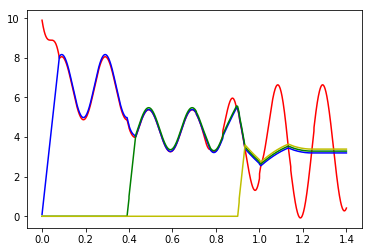

In [31]:
plt.plot(results["time"], results["outputs[1]"], 'r',
         results["time"], results["outputs[2]"], 'b',
         results["time"], results["outputs[3]"],  'g',
         results["time"], results["outputs[4]"], 'y')
plt.show()

Plot the inputs

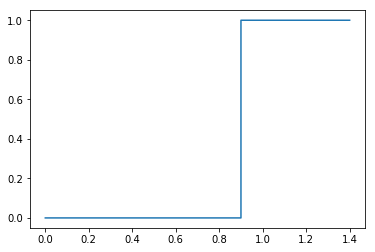

In [32]:
plt.plot(results["time"], results["inputs"])

A log entry is written each time a ModelResponse object is received from the FMUModelHandler instance. Having a priori knowledge about how much the simulated time advances between two consecutive ModelResponses (in this case, approximately 0.001 seconds) allows to define the following:

t = simulated time elapsed since beginning of the experiment

tau = wall-clock time elapsed since beginning of the experiment

t/tau = real-time performance coefficient

Let's plot the t/tau metric for the current demo (slight preprocessing involved)

In [46]:
results['timestamp'] = pd.to_datetime(results['timestamp'])

In [56]:
results['elapsed_wallclock'] = pd.to_timedelta(results['timestamp']).dt.total_seconds() - \
pd.to_timedelta(results['timestamp']).dt.total_seconds().iloc[0]

C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


In [57]:
results.head()

,timestamp,inputs,outputs[1],outputs[2],outputs[3],outputs[4],time,elapsed_wallclock
0,2019-11-04 19:37:49.248433,0.0,9.900000,0.100000,0.0,0.0,0.000,0.000000
1,2019-11-04 19:37:49.273500,0.0,9.830909,0.199993,0.0,0.0,0.001,0.025067
2,2019-11-04 19:37:49.353720,0.0,9.764791,0.299985,0.0,0.0,0.002,0.105287
3,2019-11-04 19:37:49.427922,0.0,9.701614,0.399974,0.0,0.0,0.003,0.179489
4,2019-11-04 19:37:49.432639,0.0,9.641340,0.499962,0.0,0.0,0.004,0.184206


In [58]:
t_per_tau = results["time"].divide(results["elapsed_wallclock"])

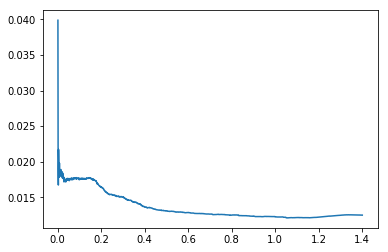

In [59]:
plt.plot(results["time"], t_per_tau)
plt.show()

## Discussion

Obviously the performance is very poor with the database operations as the bottleneck. Things could be improved substantially by introducing another means of accessing the input data, e.g., a TCP socket or similar.

See the original publication in [1] for further discussion